<a href="https://colab.research.google.com/github/Pumafi/flumy-wgan-mines/blob/main/msnwgan_3d_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
# From the git
import sys
sys.path.append('..')

In [ ]:
!python -m pip install deel.lip

In [ ]:
from models.msw_gan_3d .msw_discriminator_3d import get_discriminator_mswgan_sn_3d
from models.msw_gan_3d.msw_generator_3d import MultiScaleGenerator3D

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

from data.load_data import get_3d_flumy_data, DataGenerator
from utils.visualisation import get_color_map, visualise_slice
from utils.utils import generate_noise
from utils.visualisation import *

import os
import requests, zipfile, io

## Data  
Load the data and create a Data Generator

In [4]:
# Data sizes specifications
slice_size = (16, 32, 64, 4)

# 3D
batch_size = 20
noise_shape = (2, 4, 8)

nslices_data = 20
nslices = 16
nrows = 32
ncols = 64
sep = ","
slice_size = (nslices, nrows, ncols, 4)
filename = "./data/3D/dataFlumy3D.csv"

In [5]:
import os
import io
import requests
import zipfile
import pandas as pd
from keras.utils.np_utils import to_categorical

def get_3d_flumy_data(num_classes=4):
    filename = "./data/3D/dataFlumy3D.csv"
    data_file = './data/3D'
    dataset = "./data/3D/dataFlumy3D.csv"

    if not os.path.exists(data_file):
        os.mkdir(data_file)

    # Download data
    if not os.path.exists(dataset):
        r = requests.get("https://cloud.mines-paristech.fr/index.php/s/G4l6fHfMhWOucyj/download?path=%2F&files"
                         "=dataFlumy3D_20slices_3000img.csv.zip")
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall(data_file)
        # open(dataset, 'wb').write(r.content)

    data = pd.read_csv(filename, sep=',').values
    data = data.transpose(1, 0)

    data = data.reshape((-1, 20, 64, 128)) - 1
    # x_train = np.swapaxes(x_train.astype('int32'), 0, -1)
    data = to_categorical(data, num_classes=num_classes)
    return data

In [6]:
x_train = get_3d_flumy_data()[:3000, :16, :32, :64]
print(x_train.shape)

(3000, 16, 32, 64, 4)


In [7]:
dataloader = DataGenerator(x_train, batch_size=batch_size, dim=slice_size)

In [8]:
# (Batch size, num_slices, height, width, channels)
#(b, n, h, w, c)
serie = dataloader.__getitem__(0)
serie.shape

(20, 16, 32, 64, 4)

Visualisation

In [9]:
cmap, norm = get_color_map()
#visualisation_3d_slices(serie[0], ncols, nrows, nslices, cmap)

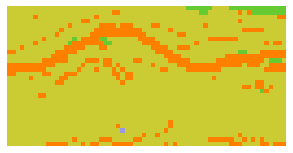

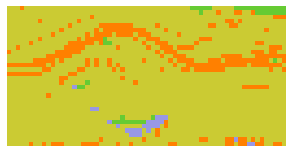

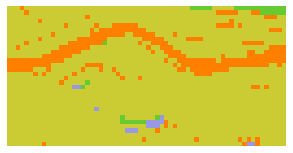

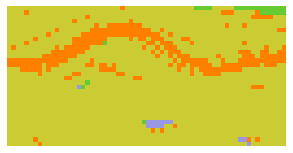

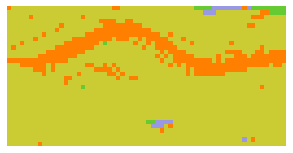

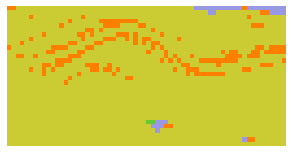

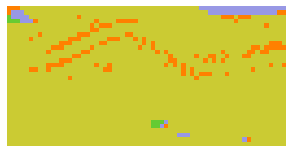

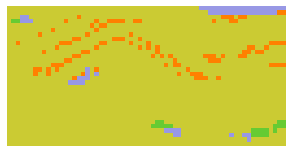

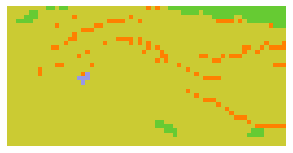

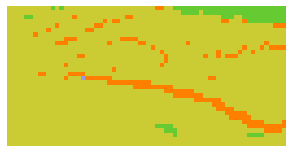

In [10]:
for i in range(10):
    visualise_slice(serie[0, i], cmap, norm, 32, 64, figsize=(5, 10))

### **Models**

In [19]:
#g_model = MultiScaleGenerator3D(output_dims=slice_size)
#g_model.build([None, *noise_shape, 1])
#generator_optimizer = keras.optimizers.Adam(learning_rate=5e-4, beta_1=0.5, beta_2=0.99) # keras.optimizers.Adam(learning_rate=5e-5, beta_1=0.5, beta_2=0.99)
#g_model.summary()

# Creating the Generator Model
g_model = MultiScaleGenerator3D(output_dims=slice_size)
g_model.build([None, *noise_shape, 1])
generator_optimizer = keras.optimizers.Adam(beta_1=0.5, beta_2=0.99)
g_model.summary()

Model: "multi_scale_generator3d_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_initial_1 (Genera  multiple                 7168      
 torInitial)                                                     
                                                                 
 generator_block_3 (Generato  multiple                 1327876   
 rBlock)                                                         
                                                                 
 generator_block_4 (Generato  multiple                 332164    
 rBlock)                                                         
                                                                 
 generator_block_5 (Generato  multiple                 83140     
 rBlock)                                                         
                                                                 
 last_generator_block_1 (Las  multiple   

In [21]:
#d_model = get_discriminator_mswgan_sn_3d(slice_size)
#discriminator_optimizer = keras.optimizers.RMSprop() #Adam(learning_rate=1e-5, beta_1=0.5, beta_2=0.99) # Adam(learning_rate=5e-5, beta_1=0.5, beta_2=0.99)
#d_model.summary()

# Creating the Discriminator Model
multiscale = (16, 32, 64, 4)

d_model = get_discriminator_mswgan_sn_3d(multiscale)
discriminator_optimizer = keras.optimizers.Adam(beta_1=0.5, beta_2=0.99)
d_model.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 16, 32, 64,  0           []                               
                                 4)]                                                              
                                                                                                  
 initial_discriminator_block_1   ((None, 8, 16, 32,   81617      ['input_5[0][0]']                
 (InitialDiscriminatorBlock)    16),                                                              
                                 (None, 1))                                                       
                                                                                                  
 input_6 (InputLayer)           [(None, 8, 16, 32,   0           []                   

In [23]:
# Creating the model
msgan = WMSGANSN3D(
    discriminator=d_model,
    generator=g_model,
    latent_shape=(*noise_shape, 1),
    discriminator_extra_steps=2,
    generator_extra_steps=3
)

msgan.compile(d_optimizer=discriminator_optimizer, g_optimizer=generator_optimizer)

In [ ]:
# Training the model - 40 epochs to show good results
epochs = 125

history = msgan.fit(dataloader, batch_size=batch_size, epochs=epochs, callbacks=[])

In [ ]:
# Error plotting
x_axis = np.arange(epochs)
plt.figure(figsize=(35, 12))
plt.subplot(1, 2, 1)
plt.title("Discriminator Loss")
plt.plot(x_axis, history.history["d_loss"])
plt.subplot(1, 2, 2)
plt.title("Generator Loss")
plt.plot(x_axis, history.history["g_loss"])
plt.show()

In [54]:
random_latent_vectors = tf.random.normal(shape=(1, *noise_shape, 1))

In [55]:
generated_images = g_model(random_latent_vectors, training=True)

In [56]:
print(serie.shape)
cmap, norm = get_color_map()
#visualisation_3d_slices(generated_images[-1], 16, 32, 16, cmap)

(20, 16, 32, 64, 4)


In [57]:
def show_multi_scale_images(array_img, cmap, norm, img_dim, i=0, epoch=0, save_img=False):

    for i in range(0, 16):
        plt.axis('off')

        plt.imshow(np.argmax(tf.squeeze(array_img[-1][:, i], axis=0).numpy(), axis=-1).reshape(img_dim), interpolation='nearest', cmap=cmap,
                  norm=norm)
        plt.show()

(4, 4, 8)
(1, 40, 16, 32, 4)


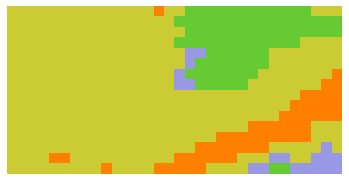

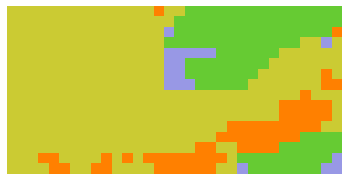

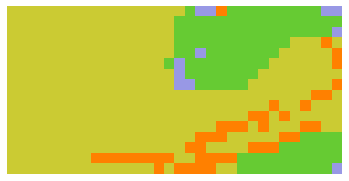

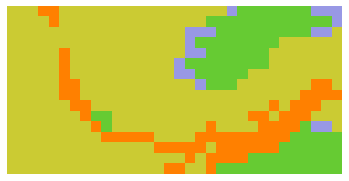

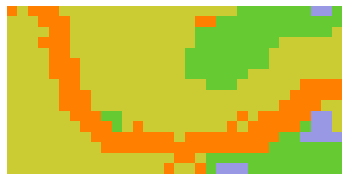

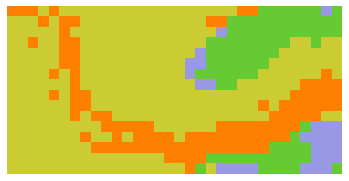

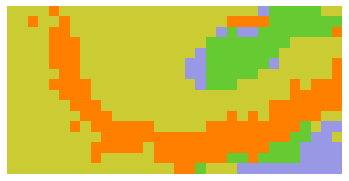

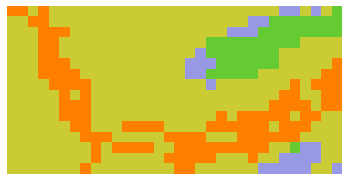

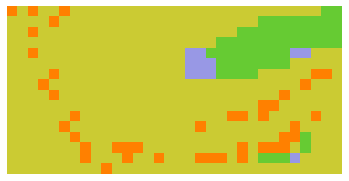

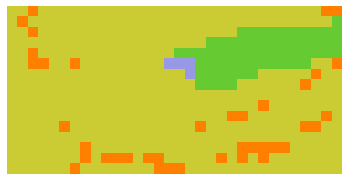

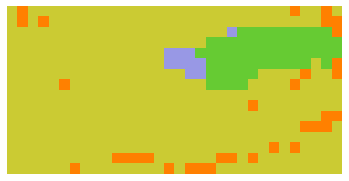

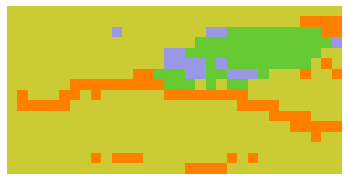

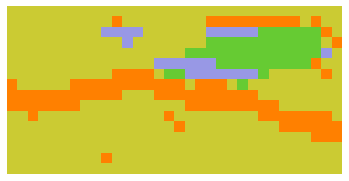

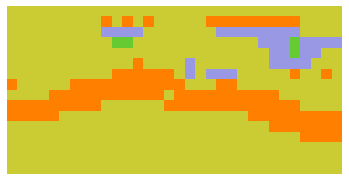

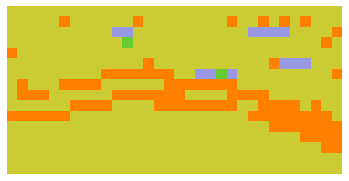

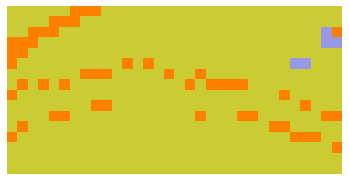

(4, 4, 8)
(1, 40, 16, 32, 4)


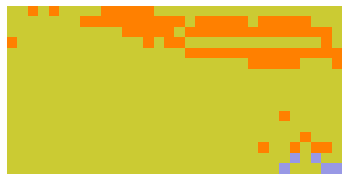

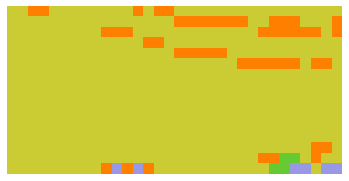

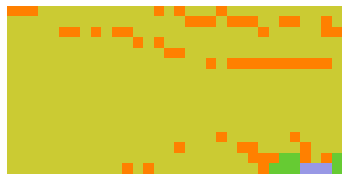

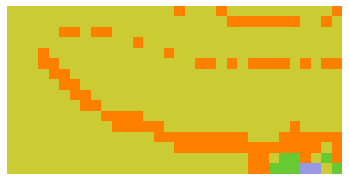

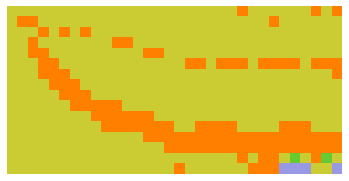

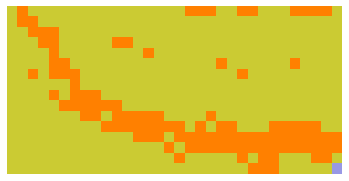

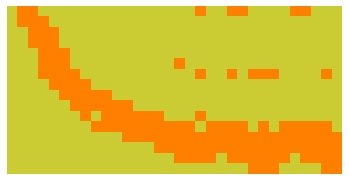

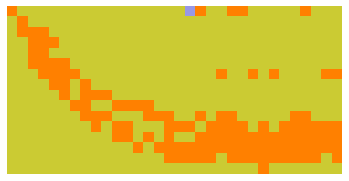

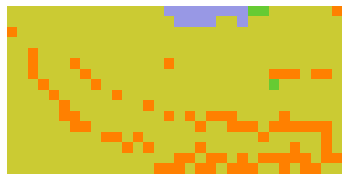

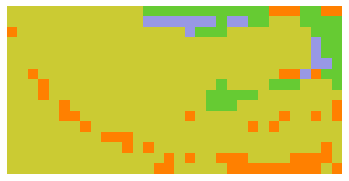

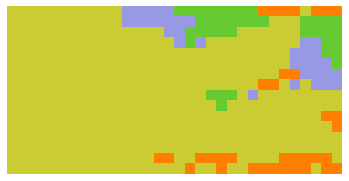

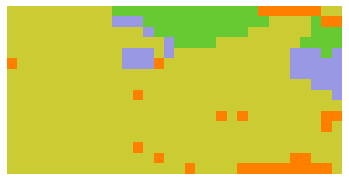

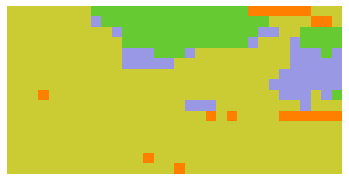

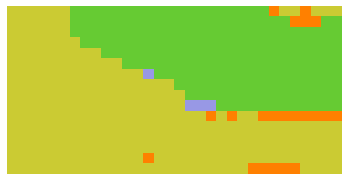

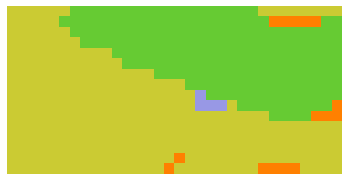

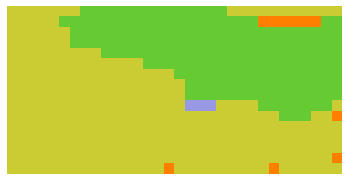

(4, 4, 8)
(1, 40, 16, 32, 4)


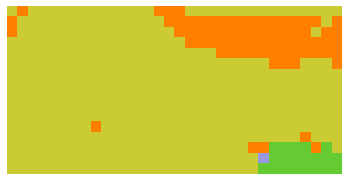

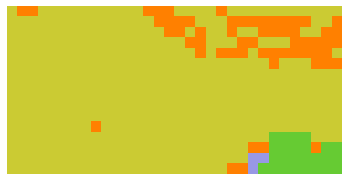

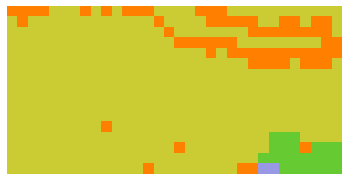

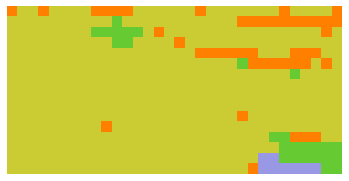

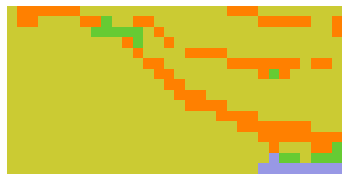

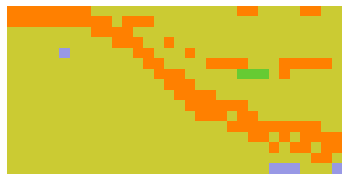

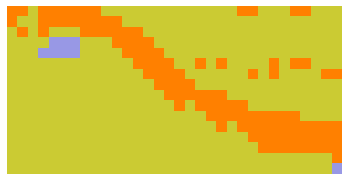

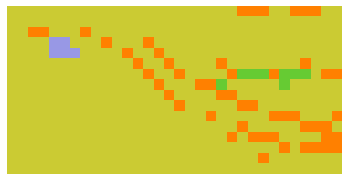

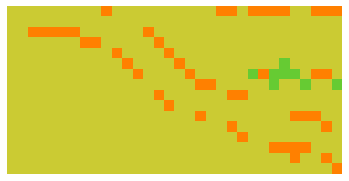

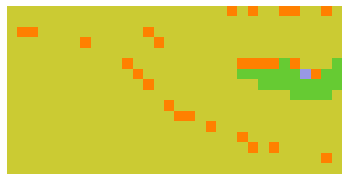

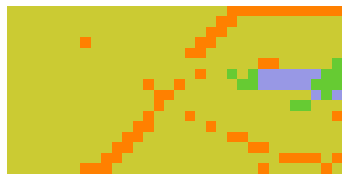

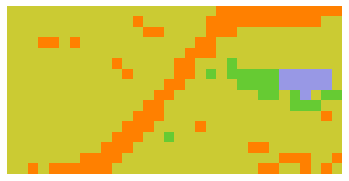

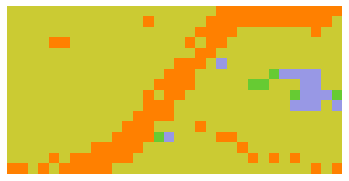

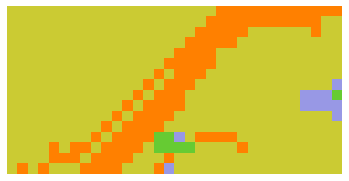

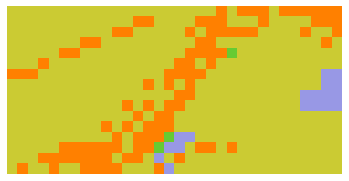

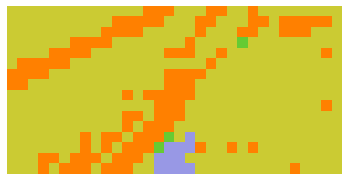

(4, 4, 8)
(1, 40, 16, 32, 4)


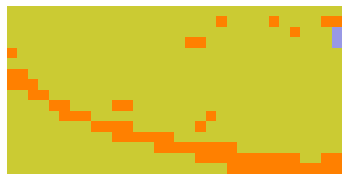

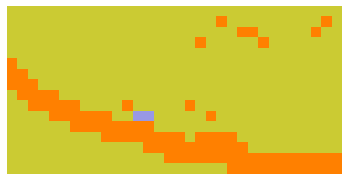

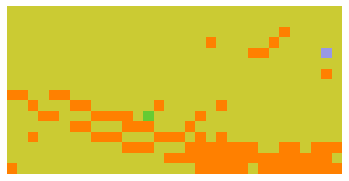

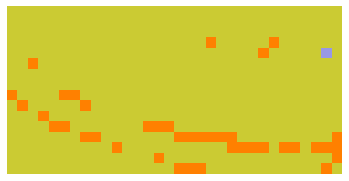

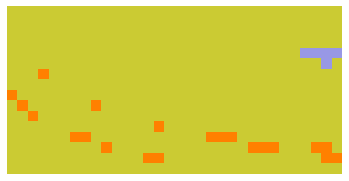

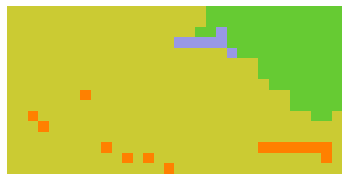

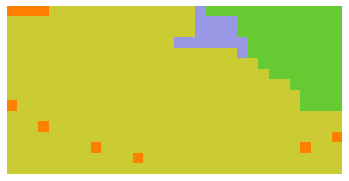

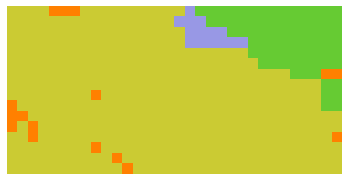

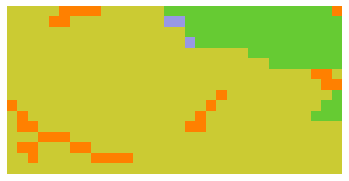

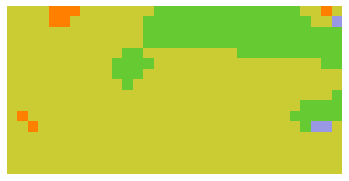

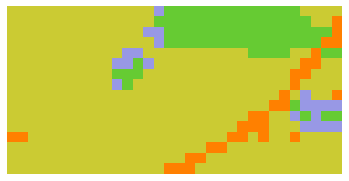

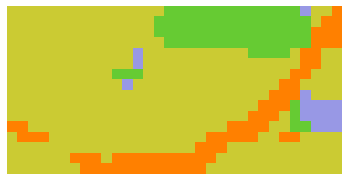

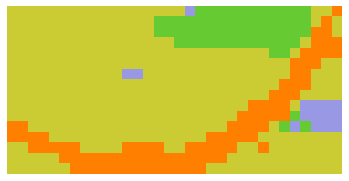

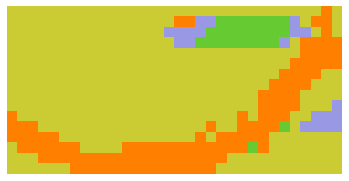

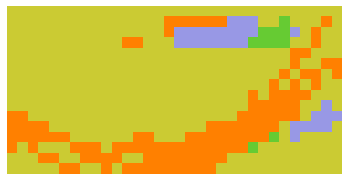

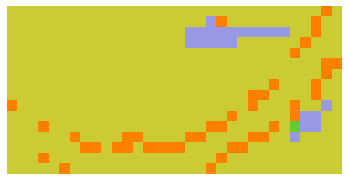

(4, 4, 8)
(1, 40, 16, 32, 4)


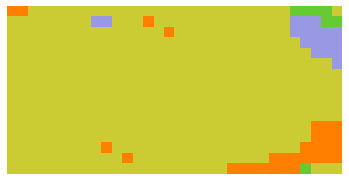

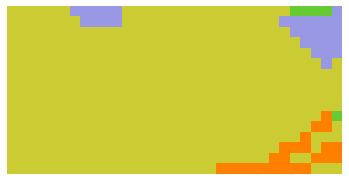

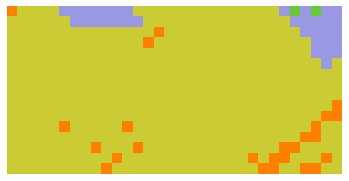

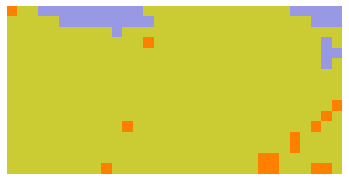

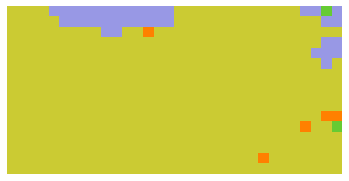

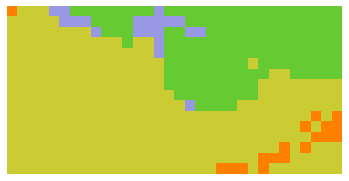

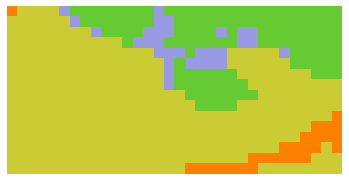

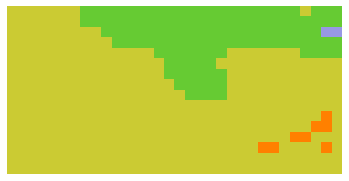

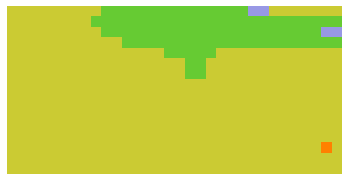

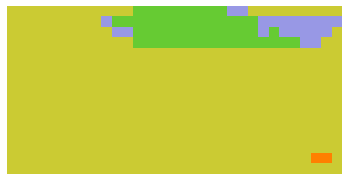

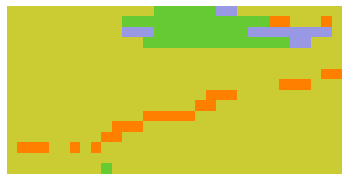

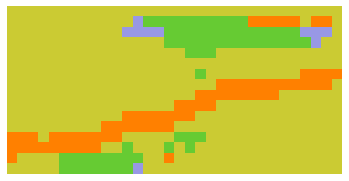

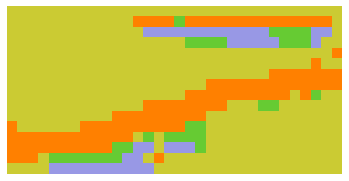

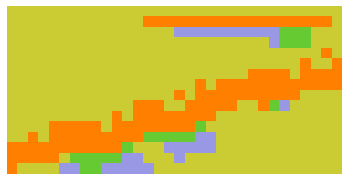

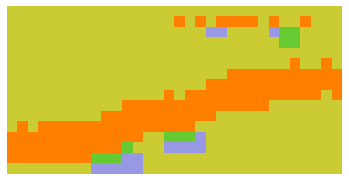

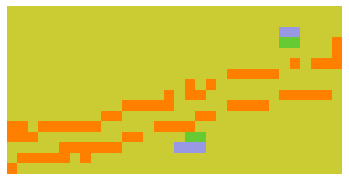

In [58]:
for i in range(5):
  print(noise_shape)
  random_latent_vectors = tf.random.normal(shape=(1, 10 ,2 ,4, 1))
  generated_images = g_model(random_latent_vectors, training=True)
  print(generated_images[-1].shape)
  show_multi_scale_images(generated_images, cmap=cmap, norm=norm, img_dim=(16, 32))

(4, 4, 8)
(1, 40, 64, 128, 4)


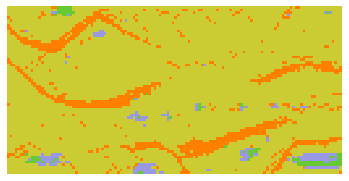

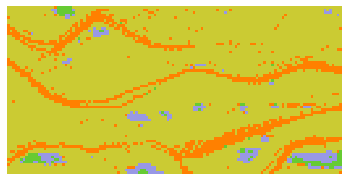

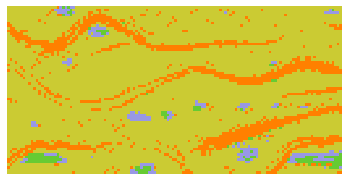

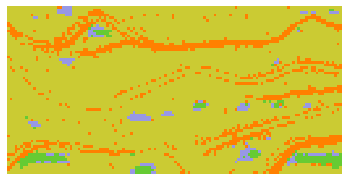

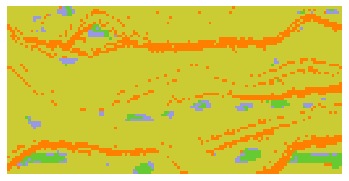

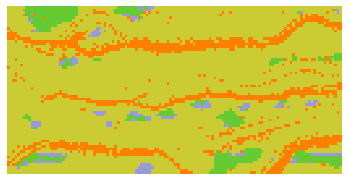

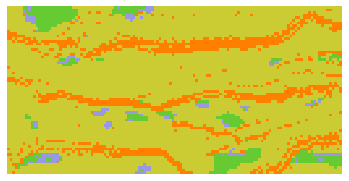

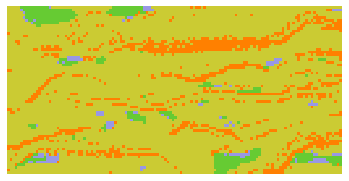

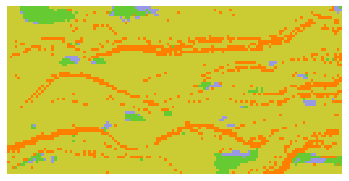

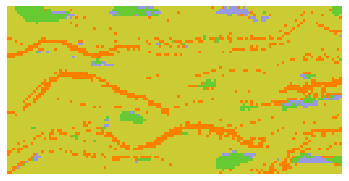

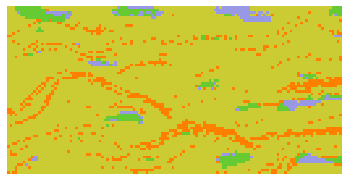

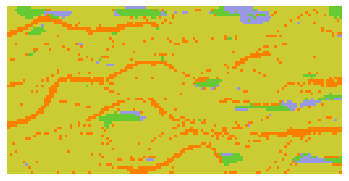

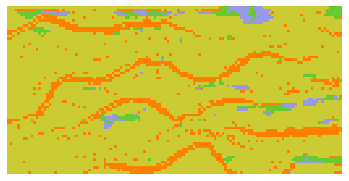

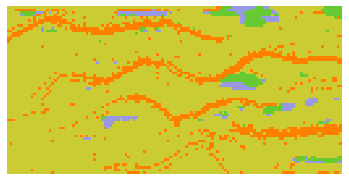

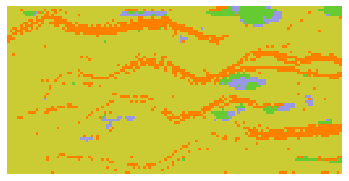

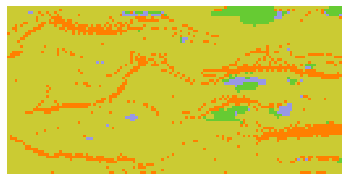

(4, 4, 8)
(1, 40, 64, 128, 4)


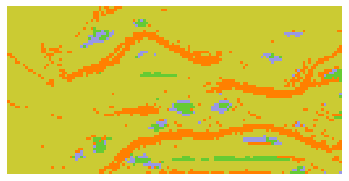

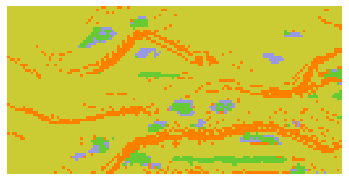

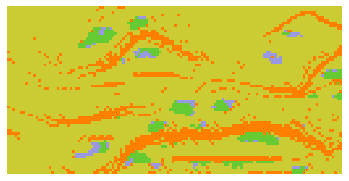

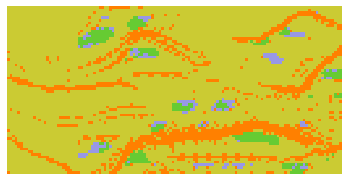

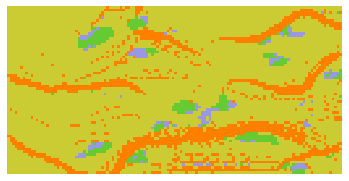

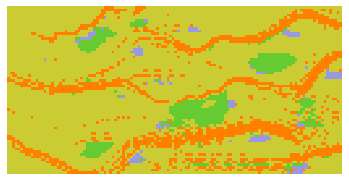

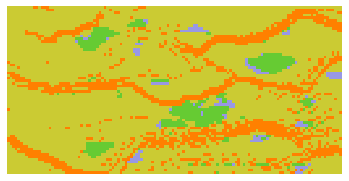

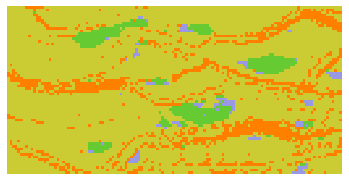

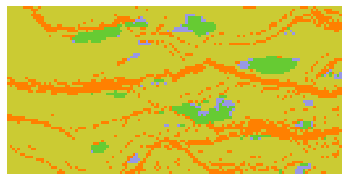

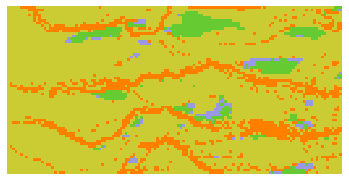

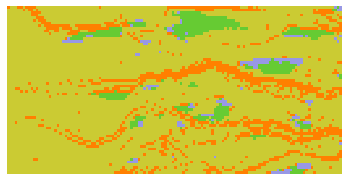

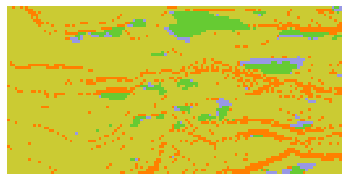

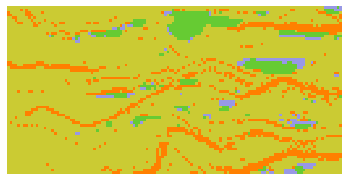

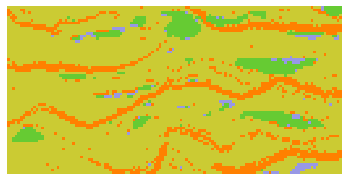

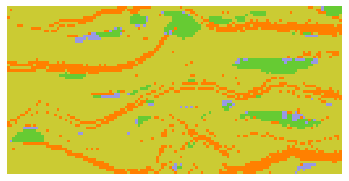

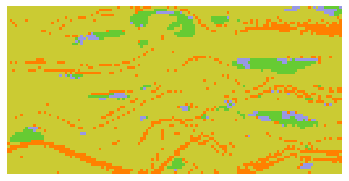

(4, 4, 8)
(1, 40, 64, 128, 4)


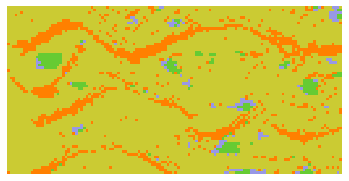

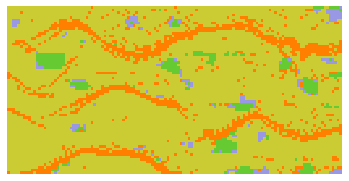

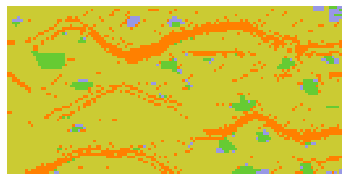

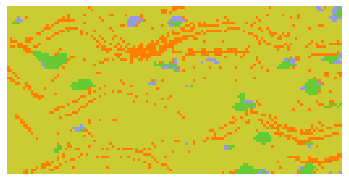

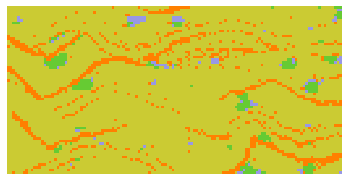

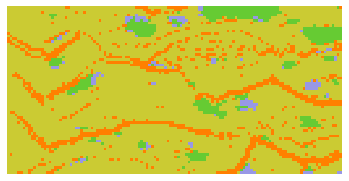

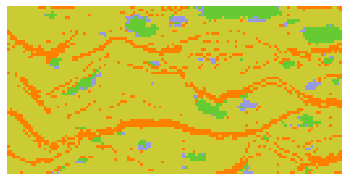

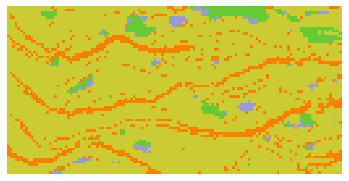

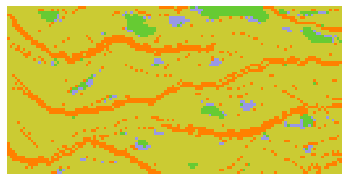

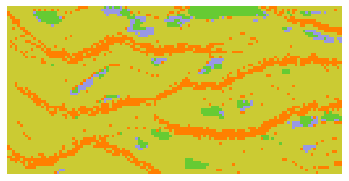

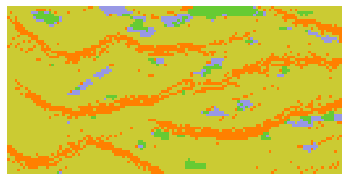

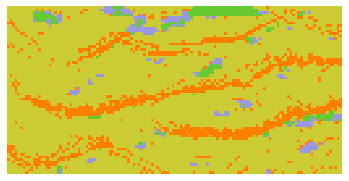

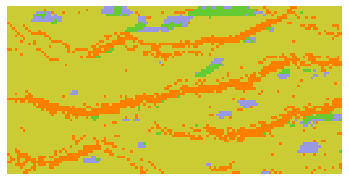

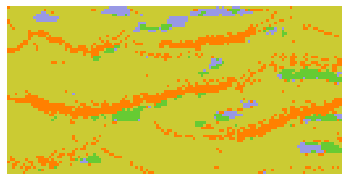

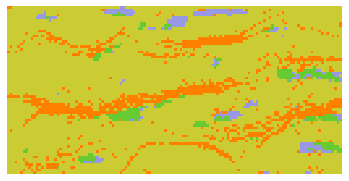

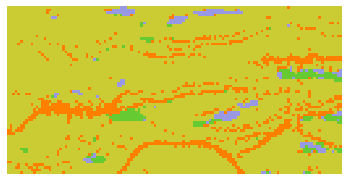

(4, 4, 8)
(1, 40, 64, 128, 4)


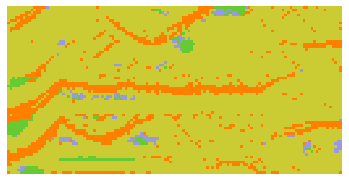

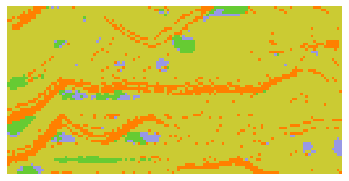

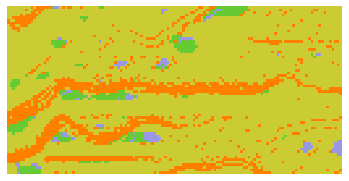

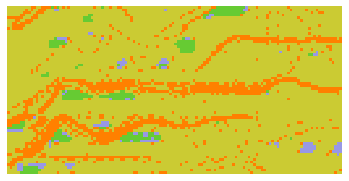

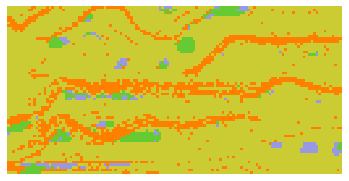

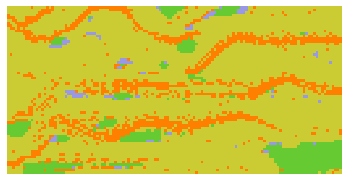

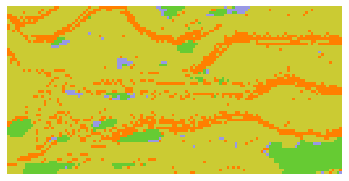

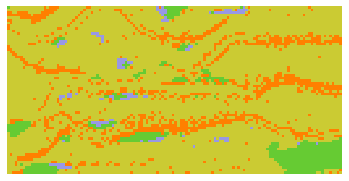

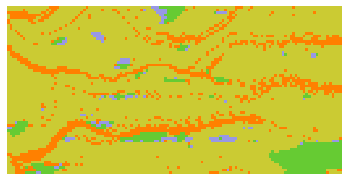

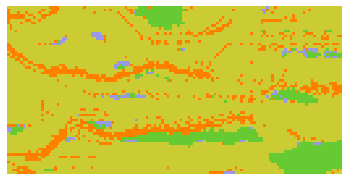

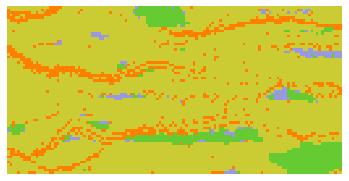

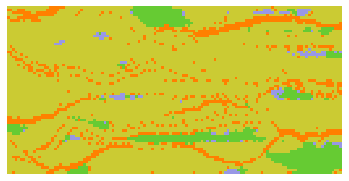

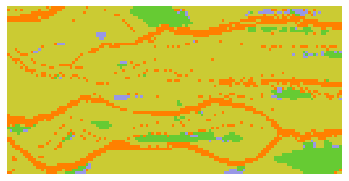

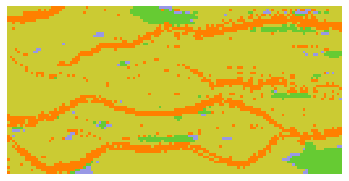

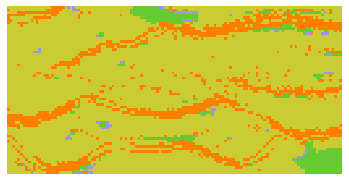

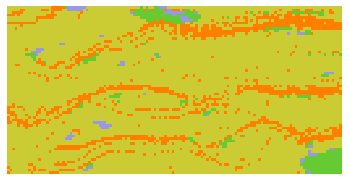

(4, 4, 8)
(1, 40, 64, 128, 4)


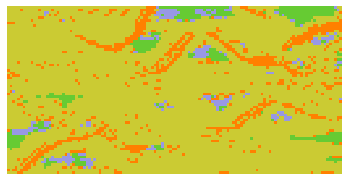

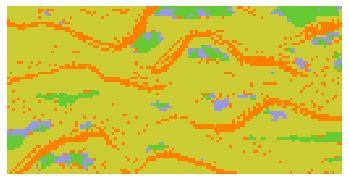

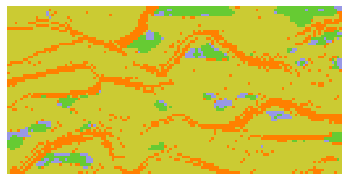

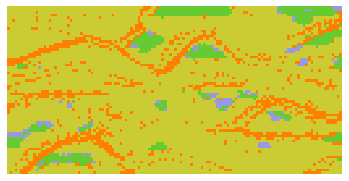

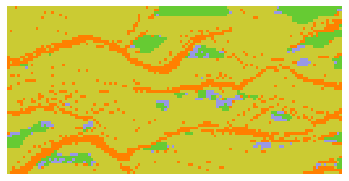

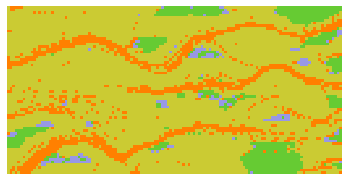

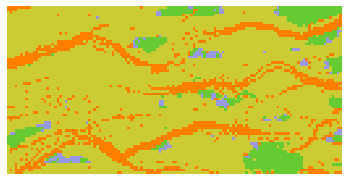

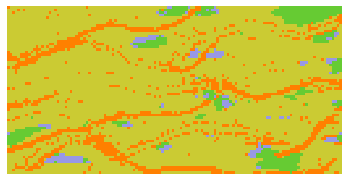

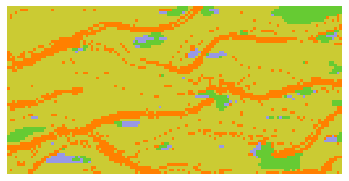

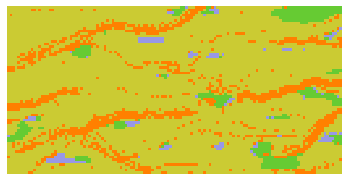

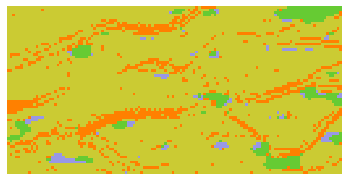

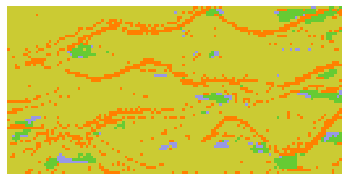

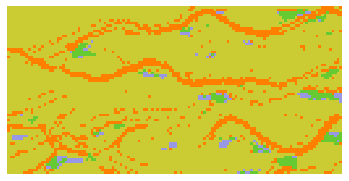

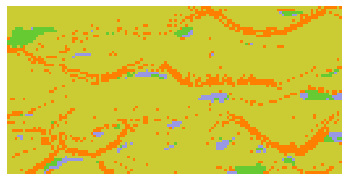

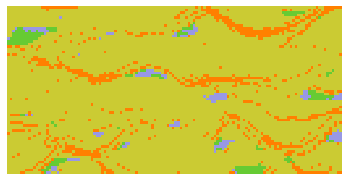

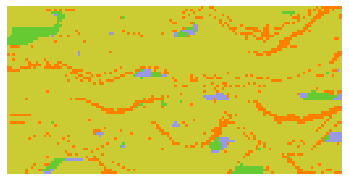

In [64]:
for i in range(5):
  print(noise_shape)
  random_latent_vectors = tf.random.normal(shape=(1, 10, 8, 16, 1))
  generated_images = g_model(random_latent_vectors, training=True)
  print(generated_images[-1].shape)
  show_multi_scale_images(generated_images, cmap=cmap, norm=norm, img_dim=(64, 128))

In [65]:
import os

SAVE_AND_TAR_RESULTS_WEIGHTS = True

if SAVE_AND_TAR_RESULTS_WEIGHTS:
  mswgan3d_checkpoint_path = "mswgan3d_weights_good/cp-mswgan3d_good.ckpt"
  mswgan3d_checkpoint_dir = os.path.dirname(mswgan3d_checkpoint_path)

  msgan.save_weights(mswgan3d_checkpoint_path)

  !tar -czvf mswgan3d_weights_good.tar.gz ./mswgan3d_weights_good

  mswgen3d_checkpoint_path = "mswgen3d_weights_good/cp-mswgen3d_good.ckpt"
  mswgen3d_checkpoint_dir = os.path.dirname(mswgen3d_checkpoint_path)

  msgan.generator.save_weights(mswgen3d_checkpoint_path)

  !tar -czvf mswgen3d_weights_good.tar.gz ./mswgen3d_weights_good

./mswgan3d_weights_good/
./mswgan3d_weights_good/cp-mswgan3d_good.ckpt.index
./mswgan3d_weights_good/checkpoint
./mswgan3d_weights_good/cp-mswgan3d_good.ckpt.data-00000-of-00001
./mswgen3d_weights_good/
./mswgen3d_weights_good/cp-mswgen3d_good.ckpt.data-00000-of-00001
./mswgen3d_weights_good/checkpoint
./mswgen3d_weights_good/cp-mswgen3d_good.ckpt.index
